# Plagiarism detector

In this notebook we will

- be using and evaluating several different Sklearn classifiers for binary classification and 
- be performing and evaluation our classifiers on multiclass data

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
import helpers
import warnings
warnings.filterwarnings('once')

sns.set_style('darkgrid')

randomstate = 12345

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Binary classification: plagiarised or not

## Loading the train and test data

In [9]:
# from nb 2 we pass the selected features as our column names
binary_class_names = ['target','c_1', 'c_3','c_8', 'c_19', 'lcs_word']

In [10]:
train_df = pd.read_csv('plagiarism_data/train.csv', header=0, names = binary_class_names)
test_df = pd.read_csv('plagiarism_data/test.csv', header=0, names = binary_class_names)

In [11]:
train_df.head()

,target,c_1,c_3,c_8,c_19,lcs_word
0,1.0,0.869369,0.613636,0.265116,0.058824,0.846491
1,1.0,0.593583,0.156757,0.027778,0.000000,0.316062
2,0.0,0.544503,0.031746,0.000000,0.000000,0.242574
3,0.0,0.329502,0.007722,0.000000,0.000000,0.161172
4,0.0,0.590308,0.035556,0.000000,0.000000,0.301653


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   target    69 non-null     float64
 1   c_1       69 non-null     float64
 2   c_3       69 non-null     float64
 3   c_8       69 non-null     float64
 4   c_19      69 non-null     float64
 5   lcs_word  69 non-null     float64
dtypes: float64(6)
memory usage: 3.4 KB


## GridSearchCV for cross-validation and model tuning
### Decision Tree

In [23]:
dectree = DecisionTreeClassifier(random_state=randomstate)

hyperparam_dict = {'criterion':['gini', 'entropy'],
                  'max_depth':list(range(2,8)),
                  'min_samples_split':[.1, .15,.2,.25,.3],
                  }


grid = GridSearchCV(dectree,
                   hyperparam_dict,
                   scoring='roc_auc', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), train_df['target'])

best_tree = opt_grid.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.9s finished


In [24]:
best_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.15,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 12345,
 'splitter': 'best'}

In [25]:
train_y_preds = best_tree.predict(train_df.drop(columns='target'))
train_y_actual = train_df['target']

roc_auc_score(train_y_actual, train_y_preds)

0.9761904761904762

This score surpasses the one we achieved in notebook 3a (roc_auc - 0.95), and without going to the limits of the maximum depth of tree. We won't go further in exploring the lower range of minimum samples for split since its best choice, 0.1, represents less than 10 data points. Let's see if we can improve on that with the other classifiers. 

### Support Vector machine

In [31]:
svclass = SVC(random_state=randomstate, max_iter=1000)

C_list = [x/10 for x in list(range(10,100,2))]
tol_list = [x/1000 for x in list(range(1, 1000, 100))]
hyperparam_dict = {'C':C_list,
                  'kernel':['rbf', 'linear', 'poly'],
                   'degree':[1,2,3],
                  'tol':tol_list
                  }


grid = GridSearchCV(svclass,
                   hyperparam_dict,
                   scoring='roc_auc', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), train_df['target'])

best_svc = opt_grid.best_estimator_

Fitting 10 folds for each of 4050 candidates, totalling 40500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 18480 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 27280 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 37680 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 40500 out of 40500 | elapsed:  1.6min finished


In [32]:
best_svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': 1000,
 'probability': False,
 'random_state': 12345,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [33]:
train_y_preds = best_svc.predict(train_df.drop(columns='target'))
train_y_actual = train_df['target']

roc_auc_score(train_y_actual, train_y_preds)

0.9166666666666667

Unfortunately the Support Vector Machine wasn't able to outdo our decision tree and find a good split across the total space of features.

### K-Nearest Neighbours Classifier

In [35]:
knn = KNeighborsClassifier()

hyperparam_dict = {'n_neighbors':list(range(3,11,2)),
                   'p':list(range(1,6))
                  }


grid = GridSearchCV(knn,
                   hyperparam_dict,
                   scoring='roc_auc', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), train_df['target'])

best_knn = opt_grid.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


In [36]:
best_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [37]:
train_y_preds = best_knn.predict(train_df.drop(columns='target'))
train_y_actual = train_df['target']

roc_auc_score(train_y_actual, train_y_preds)

0.9523809523809523

We've improved on the scores of the SVC, equalling the random forest we had previously used. However, the Decision Tree is still the best model so far. 

## Random Forest

In [38]:
rforest = RandomForestClassifier(random_state=randomstate)

hyperparam_dict = {'n_estimators':list(range(50,200,10)),
                   'criterion':['gini', 'entropy'],
                  'max_depth':list(range(2,8)),
                  'min_samples_split':[.1, .15,.2,.25,.3],
                  }


grid = GridSearchCV(rforest,
                   hyperparam_dict,
                   scoring='roc_auc', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), train_df['target'])

best_rf = opt_grid.best_estimator_

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2498 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3248 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4098 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 5048 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 6098 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7248 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 8498 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.5min finished


In [40]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [41]:
train_y_preds = best_rf.predict(train_df.drop(columns='target'))
train_y_actual = train_df['target']

roc_auc_score(train_y_actual, train_y_preds)

0.9642857142857143

Our Random Forest came very close to matching our decision tree. Given the lessened likelihood of overfitting with a Random Forest, we'll go ahead and use this model for our final predictions. 

# Evaluating against test data

How does our best model perform on unseen data? Let's plot a confusion matrix and roc curve. 

In [74]:
test_y_preds = best_rf.predict(test_df.drop(columns=['target']))
test_y_actual = test_df['target']

rf_roc_auc = roc_auc_score(test_y_actual, test_y_preds)
print(rf_roc_auc)

rf_roc_auc_train = roc_auc_score(train_y_actual, train_y_preds)

0.9


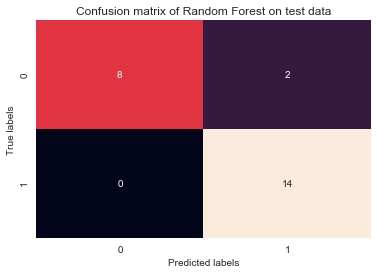

In [50]:
plt.title('Confusion matrix of Random Forest on test data')
sns.heatmap(confusion_matrix(test_y_actual, test_y_preds), annot=True, cbar=False)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show();

Based on the matrix above, our Random Forest has performed very well, only misclassifying 2 non-plagiarised answers as being plagiarised. 

**Note**: given the scarcity of test data, plotting the ROC Curve for our test data gave us a very rectangular curve with no valuable information. Below I've plotted instead the roc curve for the train data. 

In [75]:
prob_y_preds = best_rf.predict_proba(train_df.drop(columns=['target']))[:,1]

fpr, tpr, thresh = roc_curve(train_y_actual, prob_y_preds)

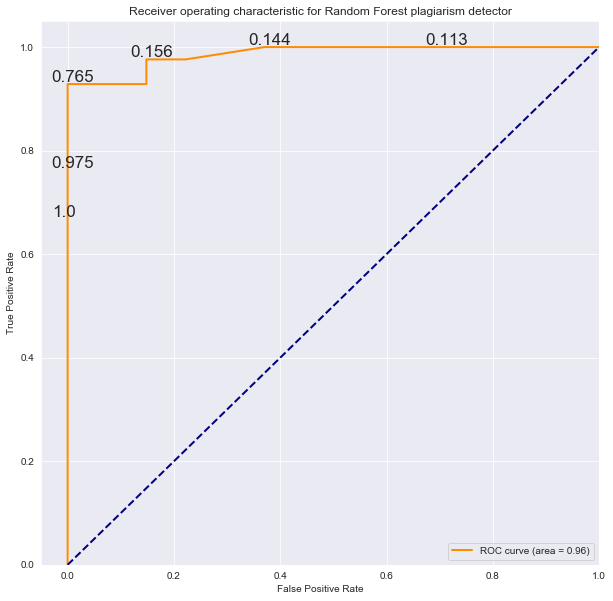

In [91]:
plt.figure(figsize=(10,10))
# linewidth, lw
lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % rf_roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Random Forest plagiarism detector')
plt.legend(loc="lower right")

plt.grid(True)

# plot some thresholds
thresholdsLength = len(thresh)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(1, thresholdsLength, 2):
    threshold_value_with_max_four_decimals = str(thresh[i])[:5]
    plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 17});
plt.show()

Generally speaking, there isn't much threshold selection we can do here, given that this curve is on train data (so no information about how threshold selection will affect out of sample predictions) and that we're able to get a True Positive Rate above 0.9 with no False Positives. Given that we're most interested in finding out where plagiarism has occurred and we're assuming that answers that are marked as 'plagiarised' will have a 2nd, manual review, we'll aim for the 1st threshold that brings our TPR up to 1.0. So, in theory, I'd be inclined to select a threshold of 0.144 for our 50-strong Random Forest. 

Of course, this naturally leads us to other questions: 
- how will the different degrees of plagiarism affect our model performances? 
- how much do we care about correctly classifying models that are highly plagiarised vs lightly plagiarised? 

# Multi-class classification

## Loading the train and test data

In [94]:
# from nb 2 we pass the selected features as our column names
multi_class_names = ['target','c_1', 'c_3','c_8', 'c_19', 'lcs_word']

In [96]:
train_df = pd.read_csv('multiclass_data/multi_train.csv', header=0, names = multi_class_names)
test_df = pd.read_csv('multiclass_data/multi_test.csv', header=0, names = multi_class_names)

In [97]:
train_df.head()

,target,c_1,c_3,c_8,c_19,lcs_word
0,2.0,0.869369,0.613636,0.265116,0.058824,0.846491
1,1.0,0.593583,0.156757,0.027778,0.000000,0.316062
2,0.0,0.544503,0.031746,0.000000,0.000000,0.242574
3,0.0,0.329502,0.007722,0.000000,0.000000,0.161172
4,0.0,0.590308,0.035556,0.000000,0.000000,0.301653


As a reminder, here's the labelling guide:
 'non':0, 
 'heavy':1, 
 'light':2, 
 'cut':3, 

* `cut`: An answer is plagiarized; it is copy-pasted directly from the relevant Wikipedia source text.
* `light`: An answer is plagiarized; it is based on the Wikipedia source text and includes some copying and paraphrasing.
* `heavy`: An answer is plagiarized; it is based on the Wikipedia source text but expressed using different words and structure. Since this doesn't copy directly from a source text, this will likely be the most challenging kind of plagiarism to detect.
* `non`: An answer is not plagiarized; the Wikipedia source text is not used to create this answer.

In [112]:
train_df.target.value_counts()

0.0    27
3.0    14
1.0    14
2.0    14
Name: target, dtype: int64

In [119]:
from sklearn.preprocessing import LabelBinarizer
y = train_df['target']
labelbin = LabelBinarizer()
multi_y_train = pd.DataFrame(labelbin.fit_transform(y), 
                       columns = ['non','heavy', 'light','cut'])
multi_y_train.head()

,non,heavy,light,cut
0,0,0,1,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [120]:
multi_y_test = pd.DataFrame(labelbin.transform(test_df['target']), 
                       columns = ['non','heavy', 'light','cut'])
multi_y_test.tail()

,non,heavy,light,cut
19,1,0,0,0
20,0,1,0,0
21,0,0,1,0
22,1,0,0,0
23,1,0,0,0


## GridSearchCV for cross-validation and model tuning
### Decision Tree

In [121]:
dectree = DecisionTreeClassifier(class_weight = 'balanced',
                                 random_state = randomstate)

hyperparam_dict = {'criterion':['gini', 'entropy'],
                  'max_depth':list(range(2,8)),
                  'min_samples_split':[.1, .15,.2,.25,.3],
                  }


grid = GridSearchCV(dectree,
                   hyperparam_dict,
                   scoring='accuracy', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), multi_y_train)

best_tree = opt_grid.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.7s finished


In [100]:
best_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.15,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 12345,
 'splitter': 'best'}

In [122]:
train_y_preds = best_tree.predict(train_df.drop(columns='target'))
train_y_actual = multi_y_train
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

accuracy_score(train_y_actual, train_y_preds)

0.7681159420289855

The score is a significant drop from the binary classification. Hopefully other models will outdo this.

### Support Vector machine

In [156]:
svclass = SVC(random_state=randomstate, max_iter=1000, class_weight='balanced')

C_list = [x/10 for x in list(range(10,100,2))]
tol_list = [x/1000 for x in list(range(1, 1000, 100))]
hyperparam_dict = {'C':C_list,
                  'kernel':['rbf', 'linear', 'poly'],
                   'degree':[1,2,3],
                  'tol':tol_list
                  }


grid = GridSearchCV(svclass,
                   hyperparam_dict,
                   scoring='accuracy', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

In [157]:
# for some reason SVC doesn't accept the multi_y_train, binarised target values, it returns a shape error after 
# all fitting is done. For that reason I've temporarily placed just the non-binarised values instead
opt_grid = grid.fit(train_df.drop(columns='target'), train_df['target'])

best_svc = opt_grid.best_estimator_

Fitting 10 folds for each of 4050 candidates, totalling 40500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 10832 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 22032 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 28584 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 35184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 40500 out of 40500 | elapsed:  1.2min finished


In [159]:
best_svc.get_params()

{'C': 5.8,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': 1000,
 'probability': False,
 'random_state': 12345,
 'shrinking': True,
 'tol': 0.901,
 'verbose': False}

In [162]:
train_y_preds = best_svc.predict(train_df.drop(columns='target'))
train_y_actual = train_df.target

accuracy_score(train_y_actual, train_y_preds)

0.7246376811594203

Much like the binary classification, SVCs don't seem as well suited to this type of problem as other models. 

Unfortunately the Support Vector Machine wasn't able to outdo our decision tree and find a good split across the total space of features.

### K-Nearest Neighbours Classifier

In [176]:
knn = KNeighborsClassifier()

hyperparam_dict = {'n_neighbors':list(range(3,11,2)),
                   'p':list(range(1,6))
                  }


grid = GridSearchCV(knn,
                   hyperparam_dict,
                   scoring='accuracy', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), multi_y_train)

best_knn = opt_grid.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.1s finished


In [177]:
best_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 3,
 'weights': 'uniform'}

In [178]:
train_y_preds = best_knn.predict(train_df.drop(columns='target'))
train_y_actual = multi_y_train

accuracy_score(train_y_actual, train_y_preds)

0.7971014492753623

KNearest has performed the best so far, and when considering that there are 4 categories (making random accuracy 20%).

## Random Forest

In [179]:
rforest = RandomForestClassifier(random_state=randomstate, class_weight='balanced')

hyperparam_dict = {'n_estimators':list(range(50,200,10)),
                   'criterion':['gini', 'entropy'],
                  'max_depth':list(range(2,8)),
                  'min_samples_split':[.1, .15,.2,.25,.3],
                  }


grid = GridSearchCV(rforest,
                   hyperparam_dict,
                   scoring='accuracy', 
                    n_jobs=-1, 
                    cv=10, verbose = 1)

opt_grid = grid.fit(train_df.drop(columns='target'), multi_y_train)

best_rf = opt_grid.best_estimator_

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1306 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2506 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3256 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4106 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5056 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 6106 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7256 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 8506 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.1min finished


In [180]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.1,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

In [181]:
train_y_preds = best_rf.predict(train_df.drop(columns='target'))
train_y_actual = multi_y_train

accuracy_score(train_y_actual, train_y_preds)

0.8840579710144928

Random Forest has outperformed all other classifiers by a significant margin! We will proceed with using it going forward.

# Evaluating multilabel classifier

In [188]:
test_y_preds = best_rf.predict(test_df.drop(columns='target'))
test_y_actual = multi_y_test

multi_cm = multilabel_confusion_matrix(test_y_actual, test_y_preds)

accuracy_score(test_y_actual, test_y_preds)

0.625

First we plot the separate confusion matrices for each of the four categories to see how successful we are in a "one vs the rest" approach.

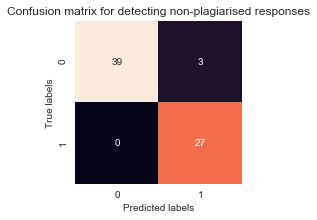

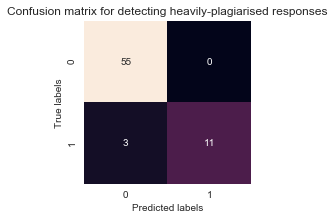

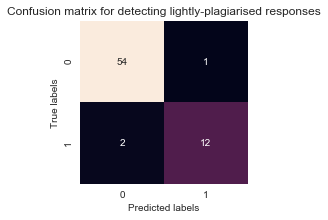

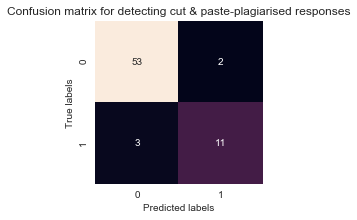

In [185]:
labels = ['non', 'heavily', 'lightly', 'cut & paste']

for i, cm in enumerate(multi_cm):
    plt.figure(figsize=(3,3))
    plt.title(f'Confusion matrix for detecting {labels[i]}-plagiarised responses')
    sns.heatmap(cm, cbar=False, annot=True)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show();

This approach doesn't tell us however which way the misclassifications go, so we plot a total confusion matrix below using the non-binarised data:

In [193]:
best_rf_reinst = RandomForestClassifier(max_depth= 6,
                                        max_features= 'auto',
                                        max_leaf_nodes= None,
                                        max_samples=None,
                                        min_impurity_decrease= 0.0,
                                        min_impurity_split= None,
                                        min_samples_leaf= 1,
                                        min_samples_split= 0.1,
                                        min_weight_fraction_leaf= 0.0,
                                        n_estimators= 60)
best_rf_reinst.fit(train_df.drop(columns='target'),train_df['target'])

test_y_preds_rf = best_rf_reinst.predict(test_df.drop(columns='target'))

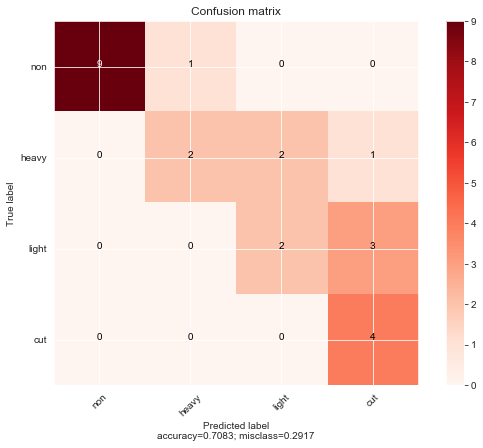

In [198]:
plot_confusion_matrix(confusion_matrix(test_df.target, test_y_preds_rf), 
                     ['non','heavy', 'light','cut'], normalize=False, cmap='Reds')
plt.show()